# Modeling the amount of water to discharge from sewage water working trench in suburb Kruiszwin Julianadorp using `ttim`

The program `ttim` is Mark Bakker's software to model multilayer aquifer systems, using analytical elements. It's available in Python via pip (see documentation by googling Mark Bakker and ttim).

@ TO 20201114, 20201206

In [26]:
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
import matplotlib
from pprint import pprint
from matplotlib.path import Path
from matplotlib.transforms import Bbox
import pandas as pd
import ttim
import pdb
import os
import sys
from importlib import reload
from scipy.special import exp1
from scipy.integrate import quad

sys.path.insert(0, '/Users/Theo/GRWMODELS/python/tools/')
sys.path.insert(0, '/Users/Theo/GRWMODELS/python/Nectaerra/Kruiszwin/src/')
import shape.shapetools as sht

gis  = '/Users/Theo/GRWMODELS/python/Nectaerra/Kruiszwin/data/spatial/'
home = '/Users/Theo/GRWMODELS/python/Nectaerra/Kruiszwin/'

import kruiszwin as kzw

os.chdir(home)
!pwd

/Users/Theo/GRWMODELS/python/Nectaerra/Kruiszwin


# Generalities

In [43]:
attribs = lambda obj: [o for o in dir(obj) if not o.startswith('_')]

def lss():
    """Return next linestyle in sequence."""
    ls_ = ['solid', 'dashed', 'dash_dot', 'dotted']
    for i in range(100):
        yield ls_[i % len(ls_)]

        
def clrs():
    """Return next color in sequence"""
    clr_ = 'rbgkmc'
    for i in rang(100):
        yield clr_[i % len(clr_)]

        
def newfig(title="title?", xlabel="xlabel?", ylabel="ylabel?",
           xlim=None, ylim=None, xscale='linear', yscale='linear',
           size_inches=(14, 6), fontsize=15):
    """Generate a new axes on a new figure and return the axes."""
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.grid()
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

    return ax

def sTheis(kD=None, S=None, r=None, Q=None, times=None):
    """Return Theis drawdown.
    
    Parameters
    ----------
    kD: float
        transmissivity
    S: float
        storage coefficient
    r: float(s)
        distance from well
    Q: float
        extraction
    times: float(s)
        times
    """
    u = r ** 2 * S / (4 * kD * times)
    return Q / (4 * np.pi * kD) * exp1(u)


def W(u=None, rho=0):
    """Return Hantush's well function
    
    The default rho=0 yields Theis
    
    """
    def kernel(y=None, rho=None):
        return np.exp(-y - (rho/2) ** 2 /y) / y
    
    def w(u, rho):
        "Return integrated values as np.array([(value, error)])"
        return quad(kernel, u, np.inf, args=(rho))
    
    wH  = np.frompyfunc(w, 2, 1) # turn w into  a regular u np.func

    return np.array([v[0] for v in wH(u, rho)]) # strip error from sequence and turn into array


def sHant(kD=None, S=None, c=None, r=None, Q=None, t=None):
    """Return Hantus drawdown."""
    
    u = r ** 2 * S / (4 * kD * t)
    rho = r / np.sqrt(kD * c)
    
    return Q /  (4 * np.pi * kD) * W(u, rho)

# Check type curves for Theis and Hantush

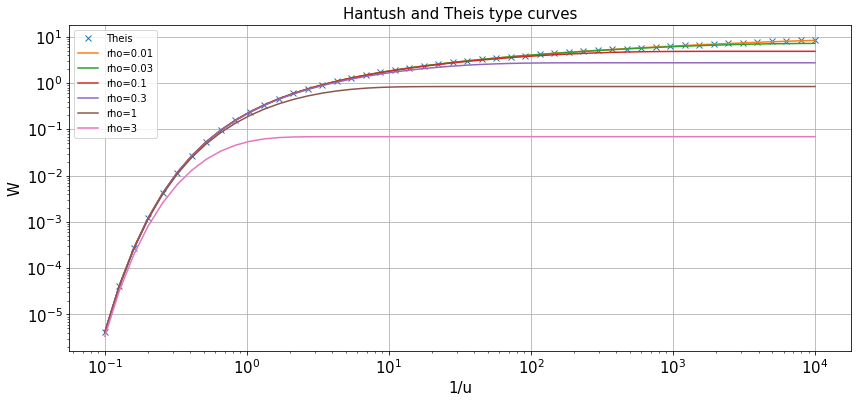

In [39]:
u = np.logspace(-4, 1, 50)
rhos = [0.01, 0.03, 0.1, 0.3, 1, 3]

ax = newfig("Hantush and Theis type curves", "1/u", "W", xscale='log', yscale='log')
ax.plot(1/u, exp1(u), 'x', label='Theis')
for rho in rhos:
    ax.plot(1/u, W(u, rho), label='rho={:.4g}'.format(rho))
    
    
ax.legend()

# Read data

In [3]:
reload(kzw) # Necessary only when debugging.

# Parameters to generate the model. Well use this as **kwargs

# Get the data from a cross section
dirs = kzw.Dir_struct(home=home, case_folder='Kruiszwin_ttim',
    executables={'mflow':'mf2005.mac',
                 'mt3d':'mt3dms5b.mac',
                 'seawat':'swt_v4.mac'})

workbook   = os.path.join(dirs.data, "Julianadorp.xlsx")
layers_df  = pd.read_excel(workbook, sheet_name='Boringen', engine="openpyxl")
piez_df    = pd.read_excel(workbook, sheet_name='Peilbuizen',
                        skiprows=[1], index_col=0, engine="openpyxl")
soil_props = pd.read_excel(workbook, sheet_name='Grondsoort',
                           index_col=0, engine="openpyxl")
spd_df     = pd.read_excel(workbook, sheet_name='SPD', index_col=0, engine="openpyxl")

In [4]:
# Make a list of Boring objects and reset their index
borehole = dict()
borehole_names = np.unique(layers_df['name'])
for name in borehole_names:
    borehole[name] = kzw.Boring(name, layers_df.loc[layers_df['name'] == name].copy())                                        
    borehole[name].layers.index = np.arange(len(borehole[name].layers.index), dtype=int)

In [5]:
use_name = 'DKMG110' 
borehole[use_name].layers

,name,NAPtop,NAPbot,D,soiltype,stype,ibound,strthd,color,profile_width,...,por,Sy,Ss,al,rhos,rhob_dry,rhob_wet,profile_patch,layer_patch,path
0,DKMG110,0.92,-1.0,1.92,"Zand, matig vast",zand_H1,-1,0,khaki,1.25,...,0.35,0.20,0.200000,0.1,2650.0,1722.5,2072.5,"PathPatch5((-0.3125, 0.92) ...)","PathPatch5((-5, 0.92) ...)","Path(array([[-5. , 0.92],\n [-5. , -1..."
1,DKMG110,-1.00,-3.0,2.00,"Klei, zwak zandig, slap",klei_slap,1,0,silver,1.00,...,0.40,0.05,0.000020,0.1,2650.0,1590.0,1990.0,"PathPatch5((-0.25, -1) ...)","PathPatch5((-5, -1) ...)","Path(array([[-5., -1.],\n [-5., -3.],\n ..."
2,DKMG110,-3.00,-3.5,0.50,"Veen, matig vast",veen,1,0,green,1.25,...,0.50,0.20,0.000005,0.1,1200.0,600.0,1100.0,"PathPatch5((-0.3125, -3) ...)","PathPatch5((-5, -3) ...)","Path(array([[-5. , -3. ],\n [-5. , -3.5]..."
3,DKMG110,-3.50,-4.6,1.10,"Klei, siltig, slap",klei_blauw,1,-0.68,steelblue,1.00,...,0.35,0.05,0.000011,0.1,2650.0,1722.5,2072.5,"PathPatch5((-0.25, -3.5) ...)","PathPatch5((-5, -3.5) ...)","Path(array([[-5. , -3.5],\n [-5. , -4.6]..."
4,DKMG110,-4.60,-5.7,1.10,"Klei, zwak zandig, slap",klei_blauw,1,-0.68,steelblue,1.00,...,0.35,0.05,0.000011,0.1,2650.0,1722.5,2072.5,"PathPatch5((-0.25, -4.6) ...)","PathPatch5((-5, -4.6) ...)","Path(array([[-5. , -4.6],\n [-5. , -5.7]..."
5,DKMG110,-5.70,-10.5,4.80,"Zand, los",zand_H2,-2,-0.68,gold,1.40,...,0.35,0.20,0.000048,0.1,2650.0,1722.5,2072.5,"PathPatch5((-0.35, -5.7) ...)","PathPatch5((-5, -5.7) ...)","Path(array([[ -5. , -5.7],\n [ -5. , -1..."
6,DKMG110,-10.50,-13.0,2.50,"Zand, matig vast",zand_H2,-2,-0.68,gold,1.40,...,0.35,0.20,0.000025,0.1,2650.0,1722.5,2072.5,"PathPatch5((-0.35, -10.5) ...)","PathPatch5((-5, -10.5) ...)","Path(array([[ -5. , -10.5],\n [ -5. , -1..."
7,DKMG110,-13.00,-14.0,1.00,"Klei, zandig, vast",klei_Hb,1,-0.68,gray,1.00,...,0.40,0.05,0.000010,0.1,2650.0,1590.0,1990.0,"PathPatch5((-0.25, -13) ...)","PathPatch5((-5, -13) ...)","Path(array([[ -5., -13.],\n [ -5., -14.]..."
8,DKMG110,-14.00,-14.5,0.50,"Veen, ?",veen_Hb,1,-0.68,green,1.25,...,0.50,0.05,0.000005,0.1,1200.0,600.0,1100.0,"PathPatch5((-0.3125, -14) ...)","PathPatch5((-5, -14) ...)","Path(array([[ -5. , -14. ],\n [ -5. , -1..."
9,DKMG110,-14.50,-15.5,1.00,Klei dummy op top van Pleistoceen,klei_Pleis_Top,1,-0.68,magenta,1.00,...,0.40,0.05,0.000010,0.1,2650.0,1590.0,1990.0,"PathPatch5((-0.25, -14.5) ...)","PathPatch5((-5, -14.5) ...)","Path(array([[ -5. , -14.5],\n [ -5. , -1..."


# Ttim aquifer system from borehole[name].layers

In [6]:
def lsloc(L=100., angle=90., x0=0., y0=0., n=100):
    """Return a line of length L under angle angle with center in x0, y0."""
    ex = np.cos(angle * np.pi / 180)
    ey = np.sin(angle * np.pi / 180)
    s = np.linspace(-L/2, L/2, n + 1)
    x = x0 + ex * s
    y = y0 + ey * s
    return x, y, s

In [7]:
[name for name in borehole]

['DKMG001',
 'DKMG002',
 'DKMG003',
 'DKMG004',
 'DKMG007',
 'DKMG010',
 'DKMG101',
 'DKMG102',
 'DKMG103',
 'DKMG104',
 'DKMG105',
 'DKMG107',
 'DKMG110',
 'KRW1',
 'KRW2',
 'KRW3',
 'Rioolgemaal']

In [8]:
reload(kzw)

## ==== Generate TTIM aquifer properties from layers

# Get the layers of the borehole to use for the setup of the aquifer system
layers = borehole[use_name].layers

## Make sure tmin > 0
tmin = 1e-3
tmax = 200

# Generate props aquifers and aquitards from the layers of a borehold
props, aquifs, atards = kzw.layers2aquifs_atards(layers,
                    phreatictop=True, topboundary='conf', tmin=tmin, tmax=tmax, tstart=tmin)

pprint(props)
model = ttim.ModelMaq(**props)

print("\nAqufiers:")
print(aquifs)
print("\nAquitards:")
print(atards)

{'M': 10,
 'Saq': array([2.000000e-01, 2.929000e-04, 3.404025e-01]),
 'Sll': array([6.67e-05, 2.25e-05]),
 'c': array([1550., 1250.]),
 'kaq': array([ 5. , 10. , 62.5]),
 'phreatictop': True,
 'tmax': 200,
 'tmin': 0.001,
 'topboundary': 'conf',
 'tstart': 0.001,
 'z': array([   0.92,   -1.  ,   -5.7 ,  -13.  ,  -15.5 , -200.  ])}

Aqufiers:
     top    bot       Saq   kaq
0   0.92   -1.0  0.200000   5.0
1  -5.70  -13.0  0.000293  10.0
2 -15.50 -200.0  0.340402  62.5

Aquitards:
    top   bot       Sll       c
0  -1.0  -5.7  0.000067  1550.0
1 -13.0 -15.5  0.000023  1250.0


In [9]:
# Add a linesink
# Specify tsandh (ts and h, tuples of simulation time and the head in the linesink)
lsProps = {'tsandh':[(  1e-3, -1.0)
                    ],
          'wh':'2H',           # two sided flowb
          'layers':[0],        # in which layers
          }

# Choose a line along which the heads will be computed
x0, y0, L, angle =0., 0, 100, 90
xLS, yLS, s = lsloc(L=100, angle=angle, x0=x0, y0=y0, n=5)

# Generate this linesink
ls = ttim.linesink.HeadLineSinkString(model, xy=np.vstack((xLS, yLS)).T, label='TestSink', **lsProps)

model.solve()

self.neq  5
solution complete


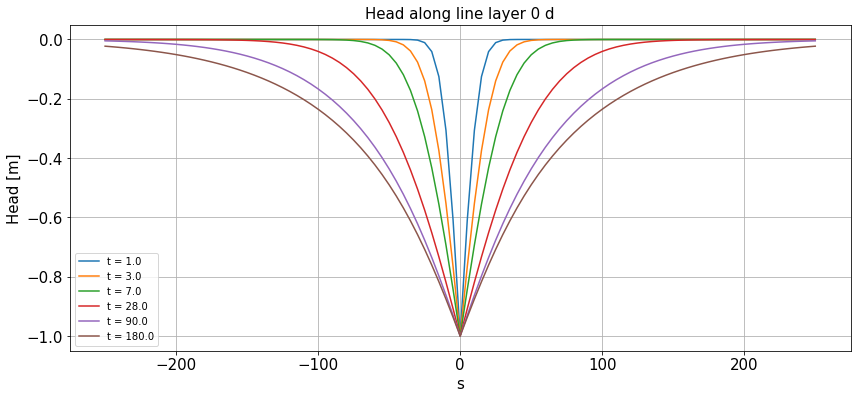

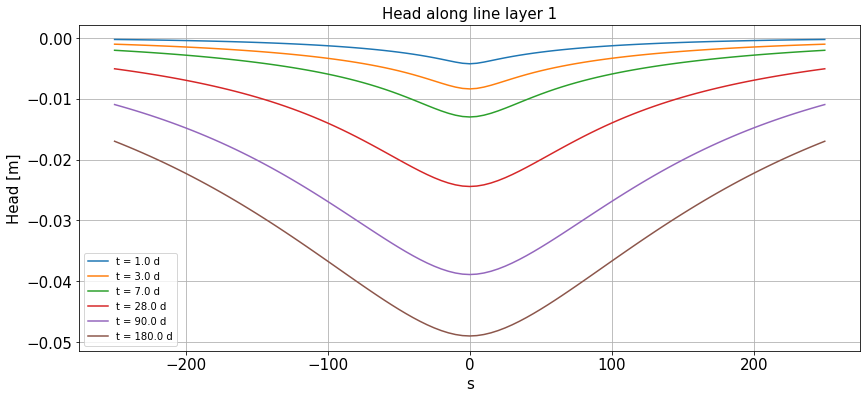

In [10]:
# Generate a line along which the heads will be computed due to all other objects in the system
x, y, s = lsloc(L=5 * L, angle=angle + 90., x0=x0, y0=y0, n=100)

# Choose a set of times
t = np.array([1, 3, 7, 28, 90, 180])

# Compute the head along the line x, y in the first and second aquifer:
h0 = model.headalongline(x, y, t, layers=0)[0]
h1 = model.headalongline(x, y, t, layers=1)[0]

ax = newfig(f"Head along line layer {0} d", "s", "Head [m]")

# Plot line for each time in aquifer0
for tt, h in zip(t, h0):
    ax.plot(s, h, label=f't = {tt:.1f}')
ax.legend()

# Plot line of each time in aquifer1
ax = newfig(f"Head along line layer {1}", "s", "Head [m]")
for tt, h in zip(t, h1):
    ax.plot(s, h, label=f't = {tt:.1f} d')
ax.legend()


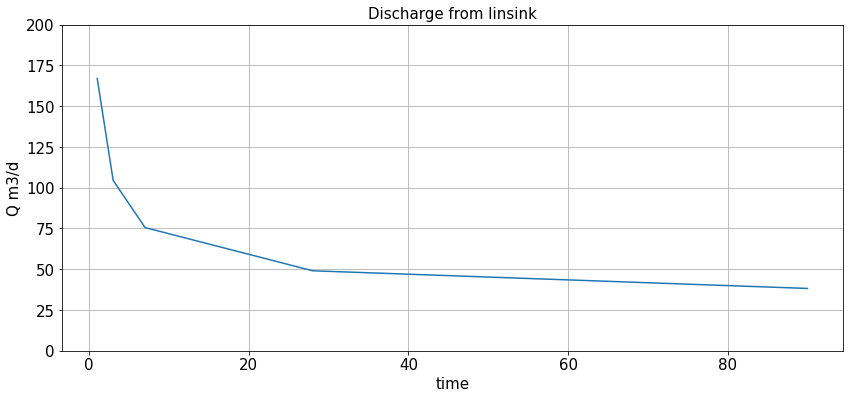

In [11]:

# The discharge of the linesink (as a function of the giveb times)
Q = ls.discharge(t)

ax = newfig("Discharge from linsink", "time", "Q m3/d", ylim=(0, 200))
ax.plot(t[:-1], Q[0][:-1], label="Discharge")

In [12]:

# Generat a Bbox that covers the data (allows all desired objects to show in the picture)
bbox = Bbox.null()
bbox.update_from_data_xy(np.vstack((xLS, yLS)).T)
bbox.update_from_data_xy(np.vstack((  x,   y)).T)

L = 50 # Keep some space around the generated bbox

# Compute a grid for spatial visualization of the heads
x0, x1, y0, y1 = bbox.x0 - L, bbox.x1 + L, bbox.y0 - 2 * L, bbox.y1 + 2 * L
dx, dy = 5., 5.
xg = np.linspace(x0, x1, int((x1 - x0) / dx + 1)) # x coordinates of the grid
yg = np.linspace(y0, y1, int((y1 - y0) / dy + 1)) # y coordinates of the grid

# The computation takes time, we'll use dots to show its evaluation.
hgr  =model.headgrid(xg, yg, t=t[-1], printrow=True)

hgr.shape # 3 layers and a single time within 32 rows 23 columns (25 m in between the grid lines).

.........................................

(3, 1, 41, 121)

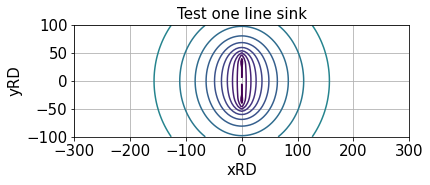

In [13]:
ax = newfig("Test one line sink", "xRD", "yRD", size_inches=(6, 12))

# we gaan verder werken met het quad object dat contour afscheidt. Dat bevat alle info van de contourlijnen.
levels= np.linspace(-1, 1, 21)
cobj = ax.contour(xg, yg, hgr[0, -1], levels=levels)
    
# En de aspect ratio, zodat km in beide richtingen even groot zijn.
ax.set_aspect(1)

# Modelleren met Ttim

In [14]:
## Aquifer properties from layers
layers = borehole[name].layers

t = np.array([1, 3, 7, 28, 90, 180, 360, 720, 1440])

## Make sure tmin > 0
tmin = 1e-3
tmax = 200
props, _, _ = kzw.layers2aquifs_atards(layers,
                    phreatictop=True, topboundary='conf', tmin=tmin, tmax=t[-1], tstart=tmin)

pprint(props)
model = ttim.ModelMaq(**props)

{'M': 10,
 'Saq': array([0.2     , 0.000965, 0.00441 ]),
 'Sll': array([1.444e-04, 4.000e-05]),
 'c': array([1266.66666667,  500.        ]),
 'kaq': array([ 5. , 10. , 62.5]),
 'phreatictop': True,
 'tmax': 1440,
 'tmin': 0.001,
 'topboundary': 'conf',
 'tstart': 0.001,
 'z': array([  0.93,  -1.2 ,  -5.  , -17.  , -19.  , -40.  ])}


In [15]:
# Add a linesink
# Specify tsandh (ts and h, tuples of simulation time and the head in the linesink)
sleufProps = {'tsandh':[(  1e-3, -1.0)
                    ],
          'wh':'2H',           # two sided flow, i.e. width is 2H
          'layers':[0],        # in which layer?
          }
slootProps = {'tsandh':[(  1e-3, -0.0)
                    ],
          'wh':'2H',           # two sided flow, i.e. width is 2H
          'layers':[0],        # in which layers
          }

In [16]:
# Surface water is a shape dataframe, i.e. of class Shape_df
oppwater = sht.Shape_df()
# It gets its data from a shapefile
oppwater.get(os.path.join(gis, 'oppwater'))

# Trenche coordinates
xSl, ySl, s = lsloc(L=100., angle=-6., x0=111629., y0=544961., n=1)
# Turn coordinates into verts array
xySl = np.vstack((xSl, ySl)).T

In [17]:
# Add the line sinks, direct van de gedigitaliseerde straten
sleuf = ttim.linesink.HeadLineSink(model,
                                   x1=xSl[0], x2=xSl[-1],
                                   y1=ySl[0], y2=ySl[-1],
                                   label='Sleuf21_kn89', **sleufProps)

# each record of the shape_df data (a pd.DataFrame) has a 'path' field with the path of the shape of the record
lsinks = [sleuf]
for p, idx in zip(oppwater.data['path'], oppwater.data['FID']):
    # p is a Path, so p.vertices are the coordinates of this record
    lsinks.append(ttim.linesink.HeadLineSinkString(model, xy=p.vertices,
                                    tsandh=slootProps['tsandh'],
                                    wh=slootProps['wh'],
                                    layers=slootProps['layers'],
                                    label=f'sloot{idx}'))

In [18]:
model.solve()

self.neq  44
solution complete


In [19]:
L = 50 # Beetje ruimte houden rond de bbox

# Bereken een grid voor ruimtelijke visualisatie van de stijghoogten
x0, x1, y0, y1 = oppwater.bbox.x0 - L, oppwater.bbox.x1 + L, oppwater.bbox.y0 - L, oppwater.bbox.y1 + L

x0, y0 = 111350, 544800
x1, y1 = x0 + 400, y0 + 400

xg = np.linspace(x0, x1, int((x1 - x0) / 2.5 + 1))
yg = np.linspace(y0, y1, int((y1 - y0) / 2.5 + 1))

print(x0, x1)
print(y0, y1)

111350 111750
544800 545200


In [20]:
# Berekenen kost even tijd
hgr  =model.headgrid(xg, yg, t=180, printrow=True)

.................................................................................................................................................................

In [21]:
# Three layers, a time and a lattice of 32 rows by 23 columns (25 m between the lines)
print("hgr.shape: ", hgr.shape) 
print("Max value in grid: {:.5f} m".format(np.max(hgr[0, 0])))

hgr.shape:  (3, 1, 161, 161)
Max value in grid: 0.00531 m


## Contouren van de stijghoogten (grondwaterstanden)

Compute the contours of the heads and then we save them into a shapefile for use in GIS

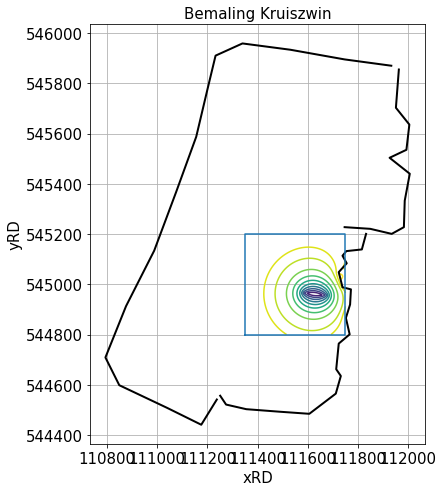

In [22]:
ax = newfig("Bemaling Kruiszwin", "xRD", "yRD", size_inches=(6, 12))

# we gaan verder werken met het quad object dat contour afscheidt. Dat bevat alle info van de contourlijnen.

# The desired contour levels
levels = np.unique(np.hstack((-0.05, np.linspace(-1, 0, 11))))

# Contour the hgr (head of the grid) and retrieve cobj, which is a quad object
cobj = ax.contour(xg, yg, hgr[0, 0], levels=levels)

# Add the surface water 
for p, idx in zip(oppwater.data['path'].values, oppwater.data['FID']):
    # Plot the path of the surface water
    ax.plot(*p.vertices.T, 'k', lw=2, label=f'sloots{idx}')
    
# Plot the bbox around the contours
ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], label='bbox heads')
    
# En de aspect ratio, zodat km in beide richtingen even groot zijn.
ax.set_aspect(1)

## How is cobj interpreted?

It has the contour levels, the number is `n`. And it has `.collections` which contains `n` `lineCollection`s the line of which can be grabbed using its `.get_paths()` method, yielding all the paths that constitute the lines pertaining to each contour level.. It is, therefore, easy to generate a shapefile that has the contour levels, so that it can be exported to a shapefile.

## Turn the cobj into a Shape_df object

Note that we can easily add other atrributes to the data of the Shape_df object.

In [184]:
def cobj2shapedf(cobj):
    """Return Shape_df object generated from contour object.
    
    We will turn the contour lines of a single level into a single path. Contour lines of a single
    level are not continuous; they generally consist of everal paths. Each contourline is therefore
    held in a linecollection object with .getpaths() as method. We turn the resulting paths into a single
    path using the path-codes to indicate where a new line starts. 
    We combine the list if paths with the levels in a pd.DataFrame. Other information pertaining to the
    contourlines can be added to this DataFrame, for instance, the time, color etc.
    
    The resulting Shape_df object, can be saved to a shapefile, which allows subsequent visualization within
    QGIS.
    
    Parameters
    ----------
    cobj: contour object
        return value from ax.contour(...)
    
    @TO 20201116
    """
    LINETO = 2
    MOVETO = 1

    paths = []
    levels = []
    for linecollection, level in zip(cobj.collections, cobj.levels):
        path = np.zeros((0, 2))
        codes = np.array([], dtype=int)
        for p in linecollection.get_paths():
            if len(p) == 0:
                continue
            path = np.vstack((path, p.vertices))
            codes = np.hstack((codes, MOVETO, LINETO * np.ones(len(p) - 1, dtype=int)))
        if len(path) > 0:
            levels.append(level)
            paths.append(Path(path, codes=codes))

    return sht.Shape_df(paths=paths, data=pd.DataFrame(levels, columns=['level']), shapeType=3)

In [185]:
reload(sht)
contours = cobj2shapedf(cobj)
contours.save(os.path.join(gis, "ttim_verlSleuf21_180d"), shapeType=3)

Shapefile saved to </Users/Theo/GRWMODELS/python/Nectaerra/Kruiszwin/data/spatial/ttim_verlSleuf21_180d>


# Test ttim for a single Theis wells

The meaning of `z` and `phreatictop` are essential.

    `z`: top and bottom of aquifers (if top is `semi`, than 2n +1 else 2n values)
    'phreatictop`: if True Saq[0] is Sy else is Ss as is the case for the lower aquifers
    
Here we simulate a single semi-confined layer TTIM and compare it with Hantush. In ttim the  layer is on top as is the case with the standard Hantush solution. The values are to check the possible drawdown in the Holocene layers between NAP -6 and -13 m, assuming the head in the Pleistocene aquifer remains zero. (In the model we put this layer on top or else we can't fix its head easily.

As the results show ttim's answer is equivalent to Hantush as expected.

The drawdown is computed for the return well at the opposite side of the building pit at xw + 4.3 and yw + 7.3 m. The results show that a drawdonw of 4.5 m is reached with 4 m3/h pumping. Further is not possible with this exatraction due to the leakage between the two layers.

self.neq  1
solution complete


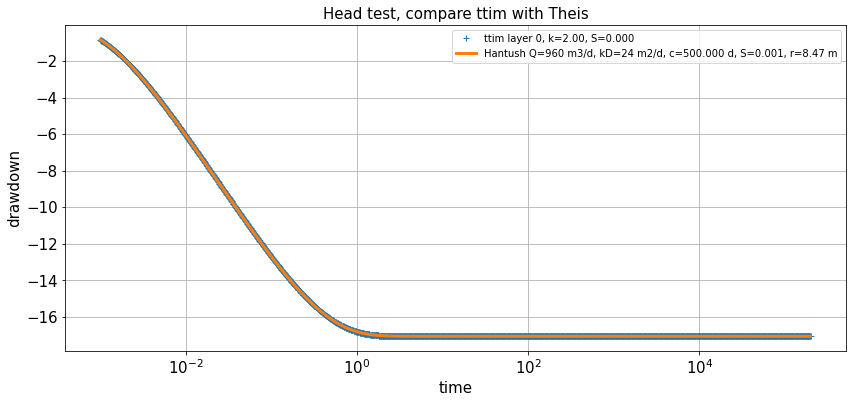

In [78]:
props = {'z': np.array([0, -5, -17]), # top and bottom of aquifers
        'kaq': np.array([2]),
        'Saq': np.array([0.0001]),
        'c': np.array([500]),
        'Sll': np.array([0]),
        'phreatictop': False, # meaning that Saq of top layer is Sy not Ss
        'tmax': 200000,
        'tmin': 0.001,
        'topboundary': 'semi', # obvious, not semi
        'tstart': 0.001,}

model = ttim.ModelMaq(**props)

xw, yw, xp, yp, Q = 0., 0., 4.3, 7.3, 24 * 40.

D  = abs(np.diff(props['z'])[1:])[0]
kD = props['kaq'][0] * D
S  = props['Saq'][0] * D
c  = props[  'c'][0]

wells={'P1': {'xw':xw, 'yw':yw, 'rw':0.175, 'tsandQ':[(0., Q)], 'res': 0., 'layers':0, 'label':'P1' }}

# Define wells
for k in wells:
    ttim.Well(model, **wells[k]),

model.solve()

times = np.logspace(-3, np.log10(200000), 2001)

r = np.sqrt((wells['P1']['xw'] - xp) ** 2 + (wells['P1']['yw'] - yp) ** 2)

hd = model.head(xp, yp, t=times)

ax = newfig("Head test, compare ttim with Theis", "time", "drawdown", xscale='log')

for i in range(hd.shape[0]):
    ax.plot(times, hd[i], '+', label='ttim layer {}, k={:.2f}, S={:.3f}'.format(i, props['kaq'][i], props['Saq'][i]))
    

    
ax.plot(times, sHant(kD=kD, S=S, c=c, r=r, Q=-Q, t=times), '-', lw=3, label='Hantush Q={:.0f} m3/d, kD={:.0f} m2/d, c={:.3f} d, S={:.3f}, r={:.2f} m'.format(Q, kD, c, Sy, r)) 

ax.legend()

# Checked!

# The meaning of z and phreaticop are essential!!

In [60]:
Sy

0.0012000000000000001

# Rioolgemaal

Voor het rioolgemaal dat in Kruiszwin wordt aangelegd is door Fa. Beemsterboer (2020) een (concept) bemalingsadvies geschreven. Dit advies is nagelopen (gerviewed) door Nectaerra (feb. 2021). De verlaging die daarin wordt voorgesteld van 4.35 wordt hier aangehouden.

De situatie is als volgt

1. Ondiepe zandlaag, mv NAP 0.93 tot NAP -1.20
1. Slappe laag NAP -1.20 tot NAP -5.00 m
1. Fijne zanden NAP -5.00 tot NAP -17 m
1. Klei NAP -17 tot -19 m
1. Pleistoceen NAP -19 tot NAP -200

1. De ondiepe bemaling geschiedt met een drain rond de bouwput.
1. De spanningsbemaling geschiedt met twee putten met filter van NAP -6 tot -13 m
1. De retourbemaling geschiedt met twee retourput met filter tussen NAP -22 en NAP -32 m

De bemaling van de ondiepe zandlaag is niet van belang voor de berekening van de bemaling in het Holoceen en de retourbemaling in het Pleistoceen.

Het gemaal wordt 2.28 x 2.28 m. Om te kunnen werken wordt 1 m ruimte rondom gerekend, dus 4.3 x 4.3 m.
De putten worden geplaatst op 1.5 m van de rand van de bouwkuip op de hoeken
x = -2.15, resp +2.15
y = -3.65, resp +3.65 (2.15 + 1.5)

In [20]:
# Specify which borehole is to be used as subsurface structure
use_name = 'Rioolgemaal' 

# Show its layers
borehole[use_name].layers

,name,NAPtop,NAPbot,D,soiltype,stype,ibound,strthd,color,profile_width,...,por,Sy,Ss,al,rhos,rhob_dry,rhob_wet,profile_patch,layer_patch,path
0,Rioolgemaal,0.93,-1.2,2.13,zand_ophooglaag,zand_H1,-1,0,khaki,1.25,...,0.350000,0.20,0.000021,0.1,2650.000000,1722.500000,2072.500000,"PathPatch5((-0.3125, 0.93) ...)","PathPatch5((-5, 0.93) ...)","Path(array([[-5. , 0.93],\n [-5. , -1..."
1,Rioolgemaal,-1.20,-5.0,3.80,"klei-veen, slap",klei_slap_veen,1,-0.68,turquoise,1.00,...,0.416667,0.10,0.000038,0.1,2166.666667,1304.166667,1720.833333,"PathPatch5((-0.25, -1.2) ...)","PathPatch5((-5, -1.2) ...)","Path(array([[-5. , -1.2],\n [-5. , -5. ]..."
2,Rioolgemaal,-5.00,-7.5,2.50,"zand, fijn, kleilenzen",zand_H2,-2,-0.68,gold,1.40,...,0.350000,0.20,0.000025,0.1,2650.000000,1722.500000,2072.500000,"PathPatch5((-0.35, -5) ...)","PathPatch5((-5, -5) ...)","Path(array([[-5. , -5. ],\n [-5. , -7.5]..."
3,Rioolgemaal,-7.50,-17.0,9.50,"wadzand, fijn tot matig fijn, silthoudend met ...",zand_H2,-2,-0.68,gold,1.40,...,0.350000,0.20,0.000095,0.1,2650.000000,1722.500000,2072.500000,"PathPatch5((-0.35, -7.5) ...)","PathPatch5((-5, -7.5) ...)","Path(array([[ -5. , -7.5],\n [ -5. , -1..."
4,Rioolgemaal,-17.00,-19.0,2.00,klei,klei_Hb,1,-0.68,gray,1.00,...,0.400000,0.05,0.000020,0.1,2650.000000,1590.000000,1990.000000,"PathPatch5((-0.25, -17) ...)","PathPatch5((-5, -17) ...)","Path(array([[ -5., -17.],\n [ -5., -19.]..."
5,Rioolgemaal,-19.00,-40.0,21.00,WVP1,zand_pleist,-3,yellow,yellow,626.00,...,0.400000,0.20,0.000210,0.1,2650.000000,1590.000000,1990.000000,"PathPatch5((-156.5, -19) ...)","PathPatch5((-5, -19) ...)","Path(array([[ -5., -19.],\n [ -5., -40.]..."


In [219]:
reload(kzw)

## ==== Generate TTIM aquifer properties from layers

# Get the layers of the borehole to be used for the setup of the aquifer system
layers = borehole[use_name].layers

## Make sure tmin > 0, values in days
tmin = 1e-3
tmax = 1e6

# Generate props aquifers and aquitards from the layers of a selected borehole
props, aquifs, atards = kzw.layers2aquifs_atards(layers,
                    phreatictop=True, topboundary='conf', tmin=tmin, tmax=tmax, tstart=tmin)

kaq = props['kaq']
Daq = props['z'][::2] - props['z'][1::2]
Saq = props['Saq']
kD = kaq * Daq
S  = props['Saq'] * Daq; S[0] = props['Saq'][0]

#props['c'][0] = 500000
#props['c'][1] = 500000

props['Sll'][:] = 0
# Show the extracted properties
pprint(props)

# Illustrate the aquifers and aquitards that were extracted from the layers
print("\nAquifers:")
print(aquifs)
print("\nAquitards:")
print(atards)

print()
print('kD =', kD)
print('Saq=', Saq)

{'M': 10,
 'Saq': array([0.2     , 0.000965, 0.00441 ]),
 'Sll': array([0., 0.]),
 'c': array([1266.66666667,  500.        ]),
 'kaq': array([ 5. , 10. , 62.5]),
 'phreatictop': True,
 'tmax': 1000000.0,
 'tmin': 0.001,
 'topboundary': 'conf',
 'tstart': 0.001,
 'z': array([  0.93,  -1.2 ,  -5.  , -17.  , -19.  , -40.  ])}

Aquifers:
     top   bot       Saq   kaq
0   0.93  -1.2  0.200000   5.0
1  -5.00 -17.0  0.000965  10.0
2 -19.00 -40.0  0.004410  62.5

Aquitards:
    top   bot  Sll            c
0  -1.2  -5.0  0.0  1266.666667
1 -17.0 -19.0  0.0   500.000000

kD = [  10.65  120.   1312.5 ]
Saq= [0.2      0.000965 0.00441 ]


# The model and the four wells

In [224]:
# Define a tim model with these properties
model = ttim.ModelMaq(**props)

# Building pit width 
rb = 2.3/ 2
bb = rb + 1
xw = bb
yw = bb + 1.5
Q = 24 * 40
QP = Q
QR = -Q

wells={'P1': {'xw':-xw, 'yw':-yw, 'rw':0.175, 'tsandQ':[(0., QP)], 'res': 0., 'layers':1, 'label':'P1' },
       'P2': {'xw':+xw, 'yw':+yw, 'rw':0.175, 'tsandQ':[(0., 0 * QP)], 'res': 0., 'layers':1, 'label':'P2' },
       'R1': {'xw':+xw, 'yw':-yw, 'rw':0.175, 'tsandQ':[(0., 0 * QR)], 'res': 0., 'layers':2, 'label':'R1' },
       'R2': {'xw':-xw, 'yw':+yw, 'rw':0.175, 'tsandQ':[(0., QR)], 'res': 0., 'layers':2, 'label':'R2' }}

# Define wells
for k in wells:
    ttim.Well(model, **wells[k]),

In [225]:
model.solve()

self.neq  4
solution complete


In [226]:
times = np.logspace(-3, np.log10(props['tmax']), 2001)


case = 2
if case == 1: # point below center of building pit
    txt = "At center below building pit."
    xp, yp = 0., 0.
elif case == 2:    # Point at boreholeface of P1
    txt = "At borehole face of well 'P1'"
    xp, yp = wells['P1']['xw'] + wells['P1']['rw'], wells['P1']['yw']
elif case == 3:  # Point installed within borehole of injection well 'R1'
    txt = "At injection well 'R1'"
    xp, yp = wells['R1']['xw'], wells['R1']['yw']
else:
    pass

r = np.sqrt((wells['P1']['xw'] - xp) ** 2 + (wells['P1']['yw'] - yp) ** 2)
hd = model.head(x=xp, y=yp, t=times)

print(txt, 'r = {:.2f} m'.format(r))

At borehole face of well 'P1' r = 0.18 m


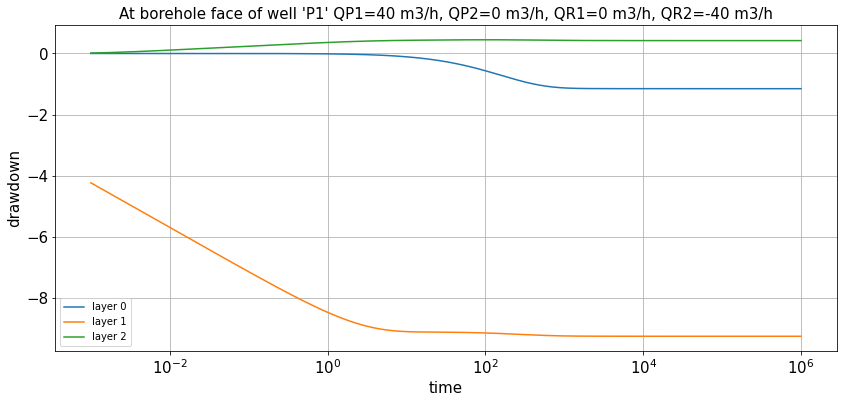

In [227]:

ax = newfig(txt + " QP1={:.0f} m3/h, QP2={:.0f} m3/h, QR1={:.0f} m3/h, QR2={:.0f} m3/h".
            format(wells['P1']['tsandQ'][0][1] / 24,
                   wells['P2']['tsandQ'][0][1] / 24,
                   wells['R1']['tsandQ'][0][1] / 24,
                   wells['R2']['tsandQ'][0][1] / 24), "time", "drawdown", xscale='log')

for i in range(hd.shape[0]):
    ax.plot(times, hd[i], label='layer {}'.format(i))
    
#ax.plot(times, sTheis(kD=kD[1], S=S[1], r=r, Q=-Q, times=times), label='kD={:.0f}, S={:.3f}'.format(kD[1], S[1]))    
#ax.plot(times, sTheis(kD=kD[2], S=S[2], r=r, Q=-Q, times=times), label='kD={:.0f}, S={:.3f}'.format(kD[2], S[2]))    

ax.legend()

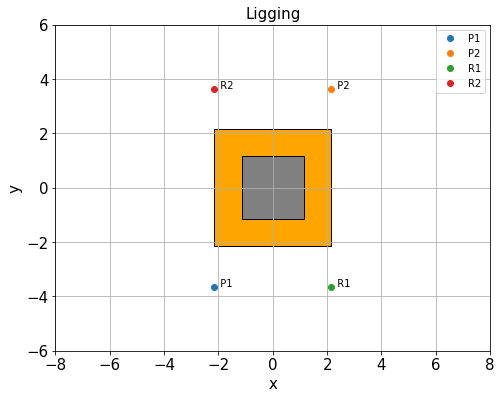

In [26]:
from matplotlib.patches import PathPatch

ax = newfig("Ligging", "x",  "y", xlim=(-8, 8), ylim=(-6, 6))
for k in wells:
    w = wells[k]
    ax.plot(w['xw'], w['yw'], 'o', label=k)
    ax.text(w['xw'], w['yw'], '  ' + k)
ax.legend()

pr = Path(np.array([[-rb, rb, rb, -rb, -rb], [-rb, -rb, rb, rb, -rb]]).T, [1, 2, 2, 2, 79])
pb = Path(np.array([[-bb, bb, bb, -bb, -bb], [-bb, -bb, bb, bb, -bb]]).T, [1, 2, 2, 2, 79])

ax.add_patch(PathPatch(pb, fc='orange'))
ax.add_patch(PathPatch(pr, fc='gray'))
ax.set_aspect(1)

# Multilayer aquifer to cover partial penetration of the pumping wells

One error occurred due to NaN's in the underlaying linear algebra, when the distance between successive layers is zero. So always keep some small gap between the base and top of two successive aquifers.

This final multilayer model proves tricky: The outcomes are completely incomprehensible. Needs secure verification using a numerical model. The three-layer model above was ok. So what's going on here?

In [183]:
props = {'M': 10,
     'Saq': np.array([0.2, 1e-4, 1e-4, 1e-4, 1e4, 1e4, 1e-4, 1e-4, 1e-4]),
 'Sll': np.ones(8) * 1.e-8,
 'c': np.array([1250.,  2e-1, 2e-1, 2e-1, 2e-1, 2e-1, 2e-1, 500.]),
 'kaq': np.array([ 5. , 10., 10., 10., 10., 10., 10., 10., 62.5]),
 'phreatictop': True,
 'tmax': 1000000,
 'tmin': 0.001,
 'topboundary': 'conf',
 'tstart': 0.001,
 'z': np.array([ 0.93, -1.2, # 0
                   -5, -6, # 1
                 -6.1, -7, # 2
                 -7.1, -8, # 3
                -8.1,  -9, # 4
                -9.1, -10., # 5
                -10.1, -13, # 6
                -13.1, -17, # 7
                -19, -40])} # 8

props

{'M': 10,
 'Saq': array([2.e-01, 1.e-04, 1.e-04, 1.e-04, 1.e+04, 1.e+04, 1.e-04, 1.e-04,
        1.e-04]),
 'Sll': array([1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08]),
 'c': array([1.25e+03, 2.00e-01, 2.00e-01, 2.00e-01, 2.00e-01, 2.00e-01,
        2.00e-01, 5.00e+02]),
 'kaq': array([ 5. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 62.5]),
 'phreatictop': True,
 'tmax': 1000000,
 'tmin': 0.001,
 'topboundary': 'conf',
 'tstart': 0.001,
 'z': array([  0.93,  -1.2 ,  -5.  ,  -6.  ,  -6.1 ,  -7.  ,  -7.1 ,  -8.  ,
         -8.1 ,  -9.  ,  -9.1 , -10.  , -10.1 , -13.  , -13.1 , -17.  ,
        -19.  , -40.  ])}

In [196]:
# Define a tim model with these properties
model = ttim.ModelMaq(**props)

# Building pit width 
rb = 2.3/ 2
bb = rb + 1
xw = bb
yw = bb + 1.5
Q = 24 * 22
QP = Q * 0
QR = -Q
players = [1, 2, 3, 4, 5, 6, 7]
rlayers = [8]

wells={'P1': {'xw':-xw, 'yw':-yw, 'rw':0.175, 'tsandQ':[(0., QP)], 'res': 0., 'layers':players, 'label':'P1' },
       'P2': {'xw':+xw, 'yw':+yw, 'rw':0.175, 'tsandQ':[(0., QP)], 'res': 0., 'layers':players, 'label':'P2' },
       'R1': {'xw':+xw, 'yw':-yw, 'rw':0.175, 'tsandQ':[(0., QR)], 'res': 0., 'layers':rlayers, 'label':'R1' },
       'R2': {'xw':-xw, 'yw':+yw, 'rw':0.175, 'tsandQ':[(0., QR)], 'res': 0., 'layers':rlayers, 'label':'R2' }}

# Define wells
for k in wells:
    ttim.Well(model, **wells[k])

In [197]:
model.solve()

self.neq  16
solution complete


In [198]:
times = np.logspace(-3, np.log10(props['tmax']), 2001)

case = 1
if case == 1: # point below center of building pit
    txt = "At center below building pit."
    xp, yp = 0., 0.
elif case == 2:    # Point at boreholeface of P1
    txt = "At borehole face of well 'P1'"
    xp, yp = wells['P1']['xw'] + wells['P1']['rw'], wells['P1']['yw']
elif case == 3:  # Point installed within borehole of injection well 'R1'
    txt = "At injection well 'R1'"
    xp, yp = wells['R1']['xw'], wells['R1']['yw']
else:
    pass

r = np.sqrt((wells['P1']['xw'] - xp) ** 2 + (wells['P1']['yw'] - yp) ** 2)
hd = model.head(x=xp, y=yp, t=times)

print(txt, 'r = {:.2f} m'.format(r))

At center below building pit. r = 4.24 m


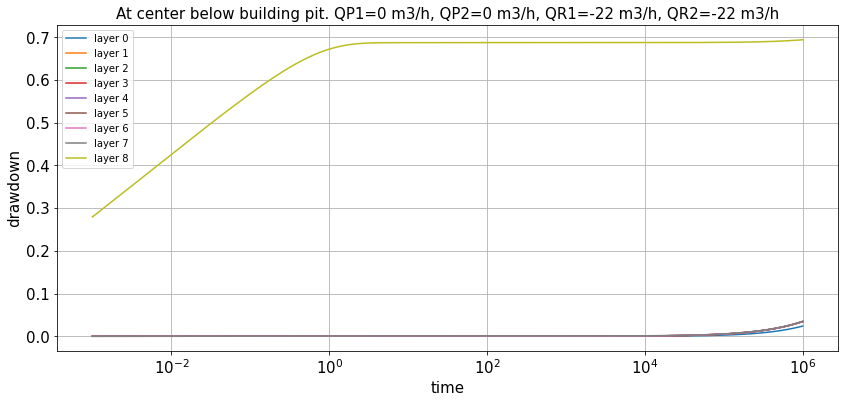

In [199]:
ax = newfig(txt + " QP1={:.0f} m3/h, QP2={:.0f} m3/h, QR1={:.0f} m3/h, QR2={:.0f} m3/h".
            format(wells['P1']['tsandQ'][0][1] / 24,
                   wells['P2']['tsandQ'][0][1] / 24,
                   wells['R1']['tsandQ'][0][1] / 24,
                   wells['R2']['tsandQ'][0][1] / 24), "time", "drawdown", xscale='log')

for i in range(hd.shape[0]):
    ax.plot(times, hd[i], label='layer {}'.format(i))
    
#ax.plot(times, sTheis(kD=kD[1], S=S[1], r=r, Q=-Q, times=times), label='kD={:.0f}, S={:.3f}'.format(kD[1], S[1]))    
#ax.plot(times, sTheis(kD=kD[2], S=S[2], r=r, Q=-Q, times=times), label='kD={:.0f}, S={:.3f}'.format(kD[2], S[2]))    

ax.legend()

The heads cannot decline forever because the head in the deep Pleistocene aqufier are kept high due to the injection wells. So this is definitely wrong. But what's causing it.

DD per log cycle is 1.5 m per log cycle

kD = 2.3 Q / (4 pi (s10t - st)) = 2.3 * (2 * 22 * 24) / (4 pi 1.5) 